#Named Entity Recognition with CRF

In [1]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
!pip3 install eli5

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(color_codes=True)
sns.set(font_scale=1)
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

from sklearn.model_selection import cross_val_predict, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, make_scorer
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
import scipy.stats
import eli5

# Dataset Load

In [5]:
df = pd.read_csv('/content/drive/MyDrive/ner_dataset.csv', encoding="latin1")

In [7]:
# make the first row as the heading, remove the first row and re-index the dataset
df.columns = df.iloc[0]
df = df[1:]
df.columns = ['Sentence#','Word','POS','Tag']
df = df.reset_index(drop=True)
df.head()

,sentence#,Word,POS,Tag
0,NaN,of,IN,O
1,NaN,demonstrators,NNS,O
2,NaN,have,VBP,O
3,NaN,marched,VBN,O
4,NaN,through,IN,O


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1048574 entries, 0 to 1048573
Data columns (total 4 columns):
 #   Column     Non-Null Count    Dtype 
---  ------     --------------    ----- 
 0   sentence#  47958 non-null    object
 1   Word       1048574 non-null  object
 2   POS        1048574 non-null  object
 3   Tag        1048574 non-null  object
dtypes: object(4)
memory usage: 32.0+ MB


In [9]:
df.shape

(1048574, 4)

In [10]:
# sentence column 이 null이 아닌 data만 사용하자
data = df[df['sentence#'].notnull()]
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 47958 entries, 23 to 1048566
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   sentence#  47958 non-null  object
 1   Word       47958 non-null  object
 2   POS        47958 non-null  object
 3   Tag        47958 non-null  object
dtypes: object(4)
memory usage: 1.8+ MB


# Exploring & Visualizing dataset

In [11]:
data.head(10)

,sentence#,Word,POS,Tag
23,Sentence: 2,Families,NNS,O
53,Sentence: 3,They,PRP,O
67,Sentence: 4,Police,NNS,O
82,Sentence: 5,The,DT,O
107,Sentence: 6,The,DT,O
131,Sentence: 7,The,DT,O
152,Sentence: 8,The,DT,O
180,Sentence: 9,Iran,NNP,B-gpe
195,Sentence: 10,Iranian,JJ,B-gpe
220,Sentence: 11,The,DT,O


In [12]:
# dataset에서 sentence를 검색
class getsentence(object):

    def __init__(self, data):
        self.n_sent = 1.0
        self.data = data
        self.empty = False
        agg_func = lambda s: [(w, p, t) for w, p, t in zip(s["Word"].values.tolist(),
                                                           s["POS"].values.tolist(),
                                                           s["Tag"].values.tolist())]
        self.grouped = self.data.groupby("sentence#").apply(agg_func)
        self.sentences = [s for s in self.grouped]

In [13]:
getter = getsentence(data)
sentences = getter.sentences
print(sentences[1])

[('Helicopter', 'NN', 'O')]


In [14]:
# the number of words in the dataset
words = list(set(data["Word"].values))
n_words = len(words)
print(n_words)

3798


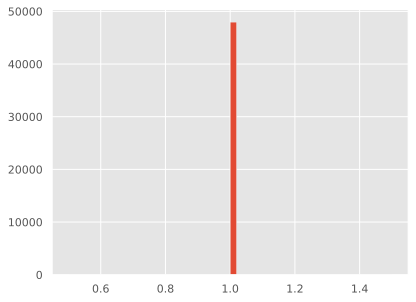

In [15]:
# visualize how the sentences are distributed by their length
## 모두 같은 길이의 문장을 가진 dataset이다.
plt.style.use("ggplot")
plt.hist([len(s) for s in sentences], bins=50)
plt.show()

In [16]:
maxlen = max([len(s) for s in sentences])
print ('Maximum sentence length:', maxlen)

Maximum sentence length: 1


In [17]:
# 각 태그에 어떤 종류의 단어가 포함되어 있는지 확인해 보자
## Words tagged as B-org
data.loc[data['Tag'] == 'B-org', 'Word'].head()

1371    Halliburton
1482            VOA
1623           ABAC
1682           ABAC
1800           ABAC
Name: Word, dtype: object

In [18]:
# Words tagged as I-org
data.loc[data['Tag'] == 'I-org', 'Word'].head()

Series([], Name: Word, dtype: object)

In [19]:
# Words tagged as B-per
data.loc[data['Tag'] == 'B-per', 'Word'].head()

1296        Khan
1531         Tim
1711    Harcourt
1860     Foreign
1890         Mr.
Name: Word, dtype: object

In [20]:
# Words tagged as I-per
data.loc[data['Tag'] == 'I-per', 'Word'].head()

Series([], Name: Word, dtype: object)

In [21]:
# Words tagged as B-geo
data.loc[data['Tag'] == 'B-geo', 'Word'].head()

617        Mosul
2589      Russia
3316    Pakistan
3747        U.S.
4819       Japan
Name: Word, dtype: object

In [22]:
# Words tagged as I-geo
data.loc[data['Tag'] == 'I-geo', 'Word'].head()

Series([], Name: Word, dtype: object)

In [23]:
# Words tagged as I-geo
data.loc[data['Tag'] == 'O', 'Word'].head()

23     Families
53         They
67       Police
82          The
107         The
Name: Word, dtype: object

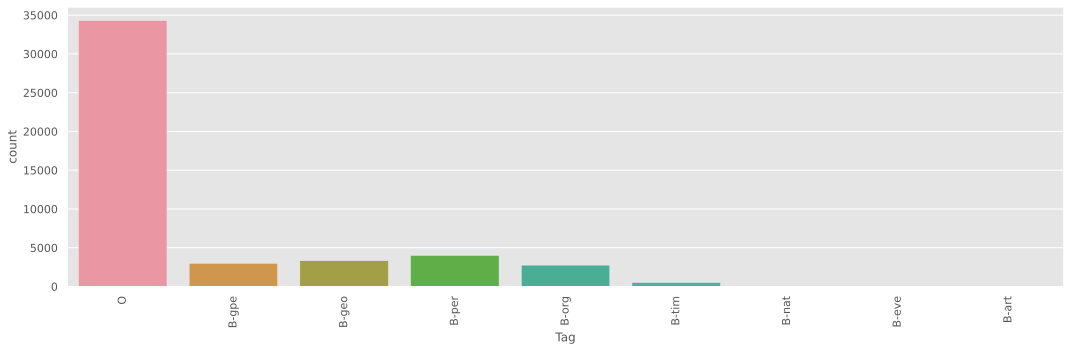

In [25]:
# Words distribution across Tags
plt.figure(figsize=(15, 5))
ax = sns.countplot(x='Tag', data=data)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha="center")
plt.tight_layout()
plt.show()

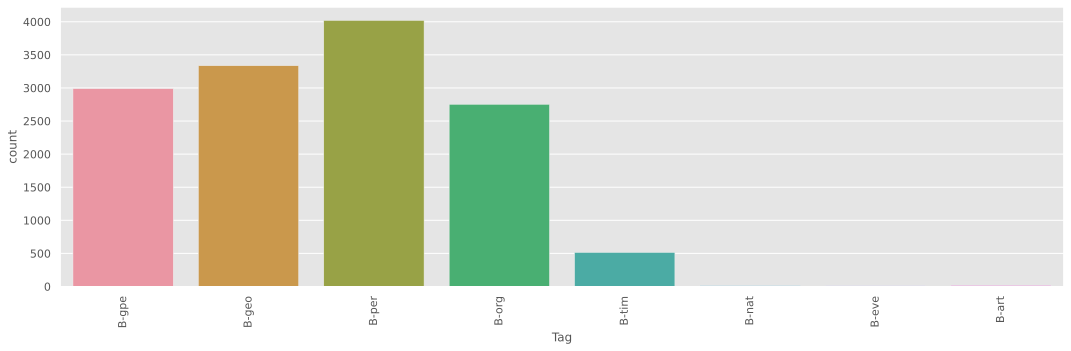

In [28]:
# most of the words are tagged as outside of any chunk
## 이것들은(tag=O) 제외하고, 다시 확인해 보자
## our dataset mostly contains words related to geopolitical entities, geographical locations and person names.

plt.figure(figsize=(15, 5))
ax = sns.countplot(x='Tag', data=data.loc[data['Tag'] != 'O'])
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha="center")
plt.tight_layout()
plt.show()

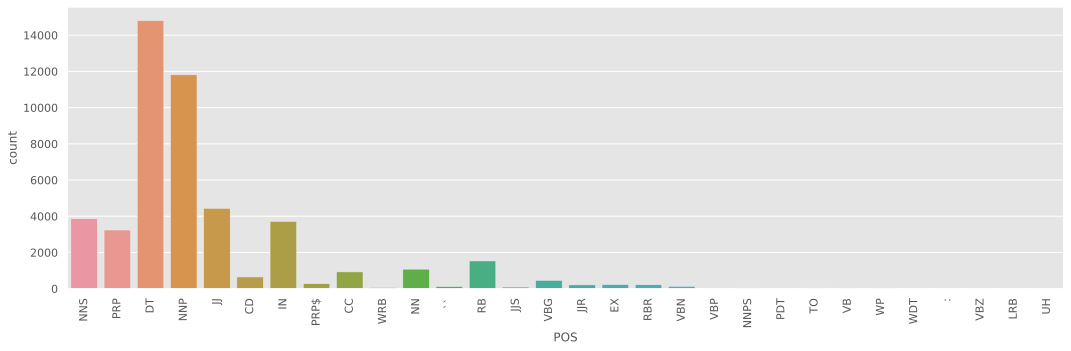

In [29]:
#Words distribution across POS

plt.figure(figsize=(15, 5))
ax = sns.countplot(x='POS', data=data, orient='h')
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha="center")
plt.tight_layout()
plt.show()

# Modeling

**Random Forest Classifier**

In [30]:
# Simple feature map to feed arrays into the classifier.
def feature_map(word):
    return np.array([word.istitle(), word.islower(), word.isupper(), len(word),
                     word.isdigit(),  word.isalpha()])

In [31]:
# Dividing the dataset into train and test sets
words = [feature_map(w) for w in data["Word"].values.tolist()]
tags = data["Tag"].values.tolist()

In [32]:
# input array
print(words[:5])

[array([1, 0, 0, 8, 0, 1]), array([1, 0, 0, 4, 0, 1]), array([1, 0, 0, 6, 0, 1]), array([1, 0, 0, 3, 0, 1]), array([1, 0, 0, 3, 0, 1])]


In [33]:
pred = cross_val_predict(RandomForestClassifier(n_estimators=20),X=words, y=tags, cv=5)

In [35]:
from sklearn.metrics import classification_report

report = classification_report(y_pred=pred, y_true=tags)
print(report)

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

       B-art       0.00      0.00      0.00        18
       B-eve       0.00      0.00      0.00        10
       B-geo       0.51      0.10      0.16      3335
       B-gpe       0.00      0.00      0.00      2989
       B-nat       0.00      0.00      0.00        11
       B-org       0.79      0.20      0.32      2752
       B-per       0.98      0.39      0.56      4019
       B-tim       0.00      0.00      0.00       515
           O       0.76      1.00      0.86     34309

    accuracy                           0.76     47958
   macro avg       0.34      0.19      0.21     47958
weighted avg       0.71      0.76      0.69     47958



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


**Conditional Random Fields classifier**

In [ ]:
!pip3 install sklearn-crfsuite

In [51]:
from itertools import chain

import nltk
import sklearn
import scipy.stats

import sklearn_crfsuite
from sklearn_crfsuite import scorers,CRF
from sklearn_crfsuite.metrics import flat_classification_report
from sklearn_crfsuite import metrics

from sklearn.model_selection import cross_val_predict
from sklearn.metrics import classification_report

In [39]:
# Feature set
def word2features(sent, i):
    word = sent[i][0]
    postag = sent[i][1]

    features = {
        'bias': 1.0,
        'word.lower()': word.lower(),
        'word[-3:]': word[-3:],
        'word[-2:]': word[-2:],
        'word.isupper()': word.isupper(),
        'word.istitle()': word.istitle(),
        'word.isdigit()': word.isdigit(),
        'postag': postag,
        'postag[:2]': postag[:2],
    }
    if i > 0:
        word1 = sent[i-1][0]
        postag1 = sent[i-1][1]
        features.update({
            '-1:word.lower()': word1.lower(),
            '-1:word.istitle()': word1.istitle(),
            '-1:word.isupper()': word1.isupper(),
            '-1:postag': postag1,
            '-1:postag[:2]': postag1[:2],
        })
    else:
        features['BOS'] = True

    if i < len(sent)-1:
        word1 = sent[i+1][0]
        postag1 = sent[i+1][1]
        features.update({
            '+1:word.lower()': word1.lower(),
            '+1:word.istitle()': word1.istitle(),
            '+1:word.isupper()': word1.isupper(),
            '+1:postag': postag1,
            '+1:postag[:2]': postag1[:2],
        })
    else:
        features['EOS'] = True

    return features

In [41]:
def sent2features(sent):
    return [word2features(sent, i) for i in range(len(sent))]

def sent2labels(sent):
    return [label for token, postag, label in sent]

In [42]:
# creating the train and test set
X = [sent2features(s) for s in sentences]
y = [sent2labels(s) for s in sentences]

In [67]:
# creating the CRF model
crf = sklearn_crfsuite.CRF(algorithm='lbfgs',
                           c1=0.1,
                           c2=0.1,
                           max_iterations=100,
                           all_possible_transitions=False
                           )

In [69]:
# predict using the same 5 fold cross validation
try:
    pred = cross_val_predict(estimator=crf, X=X, y=y, cv=5)
except:
    pass

In [73]:
# evaluation
report = classification_report(y_true=y, y_pred=pred)
print(report)

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

       B-art       0.00      0.00      0.00        18
       B-eve       0.00      0.00      0.00        10
       B-geo       0.08      0.02      0.03      3335
       B-gpe       0.00      0.00      0.00      2989
       B-nat       0.00      0.00      0.00        11
       B-org       0.05      0.01      0.02      2752
       B-per       0.08      0.03      0.05      4019
       B-tim       0.00      0.00      0.00       515
           O       0.72      0.94      0.81     34309

    accuracy                           0.68     47958
   macro avg       0.10      0.11      0.10     47958
weighted avg       0.53      0.68      0.59     47958



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [74]:
# tuning the parameters manually, setting c1 = 10
crf2 = sklearn_crfsuite.CRF(algorithm='lbfgs',
                            c1=10,
                            c2=0.1,
                            max_iterations=100,
                            all_possible_transitions=False)

In [76]:
try:
    pred = cross_val_predict(estimator=crf2, X=X, y=y, cv=5)
except:
    pass

report = classification_report(y_true=y, y_pred=pred)
print(report)

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

       B-art       0.00      0.00      0.00        18
       B-eve       0.00      0.00      0.00        10
       B-geo       0.08      0.02      0.03      3335
       B-gpe       0.00      0.00      0.00      2989
       B-nat       0.00      0.00      0.00        11
       B-org       0.05      0.01      0.02      2752
       B-per       0.08      0.03      0.05      4019
       B-tim       0.00      0.00      0.00       515
           O       0.72      0.94      0.81     34309

    accuracy                           0.68     47958
   macro avg       0.10      0.11      0.10     47958
weighted avg       0.53      0.68      0.59     47958



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
